<Observer: name='CTIO',
    location (lon, lat, el)=(-70.81500000000001 deg, -30.165277777777778 deg, 2214.999999999373 m),
    timezone=<DstTzInfo 'America/Santiago' LMT-1 day, 19:17:00 STD>>
<Observer: name='ASKAP',
    location (lon, lat, el)=(116.63699999999999 deg, -26.696000000000005 deg, 377.8299999988001 m),
    timezone=<DstTzInfo 'Australia/Perth' LMT+7:43:00 STD>>
2878.0
Night only observation for CTIO observatory only
Mulitiple ranges of Co-Vis time for ra=209.99999999999991 and dec=-63.0 in minutes: 280 mins


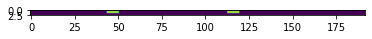

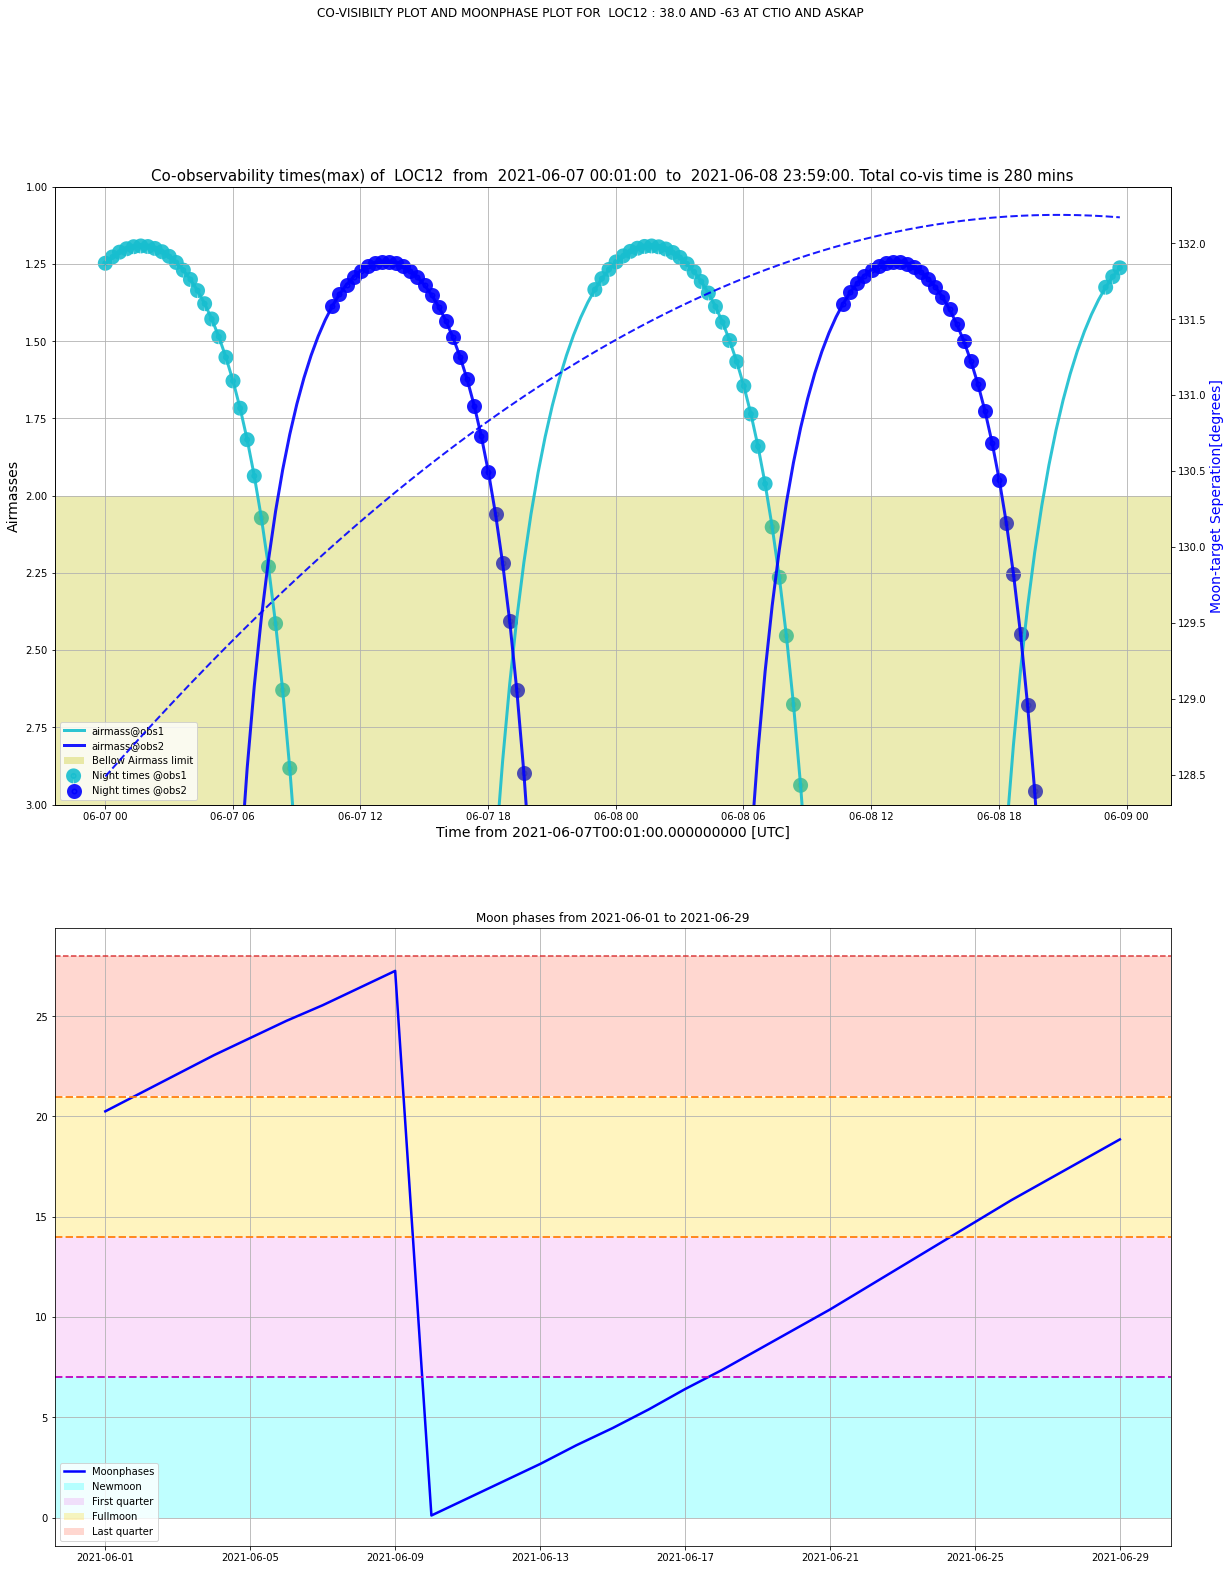

In [39]:

'''Plots the phases of the moon from  given date range. Moon phases are calculted based on Astral package.
See https://astral.readthedocs.io/en/latest/index.html for further info.

moon.phase() Calculates the phase of the moon on the specified date.

    Args:
        date: The date to calculate the phase for. Dates are always in the UTC timezone.
              If not specified then today's date is used.

    Returns:
        A number designating the phase.

        ============  ==============
        0 .. 6.99     New moon
        7 .. 13.99    First quarter
        14 .. 20.99   Full moon
        21 .. 27.99   Last quarter
        ============  ==============

'''


#load third party modules [requirements- Astropy, pandas, numpy, colorama,cv2]

from astropy.time import Time
#from astroplan import download_IERS_A 
import pandas as pd

from astropy.coordinates import EarthLocation
from astroplan import Observer,FixedTarget

from astroplan.plots import plot_airmass,plot_altitude
import astropy.units as u
from astropy.coordinates import SkyCoord
from astral import moon


import numpy as np
from pytz import common_timezones
import matplotlib.pyplot as plt
from datetime import datetime
#import datetime
import pyorbital
import cv2
#import colorama
from colorama import Fore, Style
pd.set_option("display.max_rows", None, "display.max_columns", None)

%matplotlib inline



#Specify paramenters
#Co-vis type input 'max' for maximum co-vis or 'sum' for sum of all co-vis 

#ra='09d18m06s'
#dec='-12d05m45s'

ra=38.0
dec=-63
#source_name='hydra_A'

source_name="loc12"



co_vis_type='max' #'sum' or 'max'
time_interval=20
low_airmasslim=1
high_airmasslim=3
start_date = datetime(2021,6, 7, 0, 1)
end_date = datetime(2021, 6, 8, 23, 59)


#start_date = Time('2021-06-07 00:01:00')
#end_date= Time('2021-06-08 23:59:00')


Obs1_longitude=-70.81500000000001 
Obs1_latitude=-30.165277777777778
obs1_elevation=2214.9999999993697
obs1_name='CTIO'



#Observatory 2 parameters

obs2_longitude=116.637   #lontitude of observatory 2
obs2_latitude=-26.696  #latitude of observatory 2 
obs2_elevation=377.83   #elevation of observatory 2
obs2_name='ASKAP'                  #name of observatory 2

#obs2_longitude=149.06119444444445
#obs2_latitude=-31.273361111111104
#obs2_elevation=1149.0000000015516
#obs2_name='KMTNET'

night_only_obs1= 'y' #'y'
night_only_obs2= 'n' #'n'




save_location= '/home/andrew/src/Transient-Scheduler/scripts/plots4J//'

target_coord = SkyCoord(ra, dec,  unit=(u.hourangle, u.deg))

target= FixedTarget(coord=target_coord, name=source_name)


#Observatories


obs1_coordinates = EarthLocation.from_geodetic(Obs1_longitude*u.deg,Obs1_latitude*u.deg,obs1_elevation*u.m)
obs1= Observer(location=obs1_coordinates, name=obs1_name, timezone='America/Santiago')
print(obs1)


obs2_coordinates = EarthLocation.from_geodetic(obs2_longitude*u.deg,obs2_latitude*u.deg,obs2_elevation*u.m)
obs2 = Observer(location=obs2_coordinates, name=obs2_name, timezone='Australia/Perth')
print(obs2)
##########################################################################################################
import datetime

moonphase_start_date = datetime.date(2021, 6, 1)
moonphase_end_date   = datetime.date(2021, 6, 30)

dates = [ moonphase_start_date+ datetime.timedelta(n) for n in range(int ((moonphase_end_date - moonphase_start_date).days))]
#print(dates)




#Time intervals
from datetime import datetime, timedelta

def daterange(start_date, end_date):
    delta = timedelta(minutes=time_interval)
    while start_date < end_date:
        yield start_date
        start_date += delta
        

times=[]
for single_date in daterange(start_date, end_date):
    times.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))
dt=np.array(times)

times=dt.astype(("datetime64[ns]"))
delta=end_date-start_date
total_mins = delta.total_seconds() / 60
print(total_mins)   

#dates
#print(dt)


#Get moonphases 
moonphases=[]
for i in dates:
    moonphases.append(moon.phase(i))
    
##################################################################################################


#Airmasses at observatory 1

airmass_obs1=obs1.altaz(dt, target).secz
masked_airmass_obs1 = np.ma.array(airmass_obs1, mask=airmass_obs1 < 1)

#Airmasses at observatory 2

airmass_obs2=obs2.altaz(dt,target).secz
masked_airmass_obs2 = np.ma.array(airmass_obs2, mask=airmass_obs2 < 1)


#Creating a dictionary for the dataframe
dk={'datetimes':dt,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
#dk


##################################################################################################
#Calculate Moon positions

from astropy.coordinates import get_moon

#Generate moon positions 

dt2=Time(dt)
moon_radec=[]
for i in dt2:
    get_moon(i)
    moon_radec.append(get_moon(i))

    
#convert them to radec format   
radecs=[]
for i in moon_radec:
    c = SkyCoord(ra=i.ra, dec=i.dec)
    radecs.append(c.to_string('hmsdms'))
    
#Splitting them
radec2=[]
for e in radecs:
    radec2.append(e.split(' '))
    
    
#Conveting to degrees
moon_locs=[]
l=np.arange(0,len(radec2))
for i in (l):
    moon_locs.append(SkyCoord(radec2[i][0],radec2[i][1], frame='icrs'))

#Get seperations in degrees
sep=[]
for i in moon_locs:
    sep.append(target_coord.separation(i).deg)
#making them numpy arrays
sep=np.array(sep)   
#sep


#######################################################################################################

#Extracting the night times at obseratory 1
night_index=np.where(obs1.is_night(dt,horizon= -12*u.deg)==True)
night_ams_obs1=masked_airmass_obs1[night_index]
times_x=np.array(dt)
night_times_obs1=times_x[night_index]
#print('night times obs1:',night_times_obs1)

dt_nobs1=([datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in night_times_obs1])


#Extracting the night times at obseratory 2
night_index_obs2=np.where(obs2.is_night(dt,horizon= -12*u.deg)==True)
night_ams_obs2=masked_airmass_obs2[night_index_obs2]


night_times_obs2=times_x[night_index_obs2]
dt_nobs2=([datetime.strptime(x, '%Y-%m-%d %H:%M:%S')  for x in night_times_obs2])

#print('night times obs2:',night_times_obs2)

xc=obs1.is_night(dt,horizon= -12*u.deg)
cc=obs2.is_night(dt,horizon= -12*u.deg)
#print('xc',xc)
#xx=pd.DataFrame(xc)

#print(xx)


dk={'datetimes':dt,'night_obs1':xc,'night_obs2':cc,
        'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}



if night_only_obs1=='y'and night_only_obs2=='y':
    print(f'Night only observation for BOTH Observatory {obs1.name.upper()} and {obs2.name.upper()}')
    
    dk={'datetimes':dt,'night_obs1':xc,'night_obs2':cc,
        'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
     # Dropping NaN values but maintaining indexes in case there are NANs

    df=df.dropna()#Checking the dataframe
    df.reset_index(drop=True, inplace=True)
    #print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([(df['night_obs1'] == True) & (df['night_obs2'] == True)&df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        
        if len(cb)==0:
            fullmins=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}')  
#########################################################################################


elif night_only_obs1=='y'and night_only_obs2=='n':
    print(f'Night only observation for {obs1.name.upper()} observatory only')
    
    dk={'datetimes':dt,'night_obs1':xc,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
    
    df=df.dropna()
    df.reset_index(drop=True, inplace=True)
    #print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        total_covis=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([(df['night_obs1'] == True) &df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        if len(cb)==0:
            fullmins=0
            total_covis=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}')  

####################################################################################################
        
elif night_only_obs1=='n'and night_only_obs2=='y':
    
    print(f'Night only observation for {obs2.name.upper()} observatory only')
    
    dk={'datetimes':dt,'night_obs2':cc,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
     # Dropping NaN values but maintaining indexes in case there are NANs

    df=df.dropna()#Checking the dataframe
    df.reset_index(drop=True, inplace=True)
    #print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([(df['night_obs2'] == True)&df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        if len(cb)==0:
            fullmins=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}') 
    
    
elif night_only_obs1=='n'and night_only_obs2=='n':
    
    print(f'Night only observation not required')
    
    dk={'datetimes':dt,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
     # Dropping NaN values but maintaining indexes in case there are NANs

    df=df.dropna()#Checking the dataframe
    df.reset_index(drop=True, inplace=True)
    #print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        if len(cb)==0:
            fullmins=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}') 

            
            
            
#fig, (ax) = plt.subplots(1,figsize=(15, 8))

fig, (ax, ax2) = plt.subplots(2,figsize=(20, 25))
#ax.set_figure(figsize=(15,8))

fig.suptitle(f'CO-VISIBILTY PLOT AND MOONPHASE PLOT FOR  {source_name.upper()} : {ra} AND {dec} AT {obs1.name.upper()} AND {obs2.name.upper()}  ')

ax.set_title(f"Co-observability times({co_vis_type}) of  {target.name.upper()}  from  {start_date}  to "\
           
f" {end_date}. Total co-vis time is {total_covis} mins",fontsize=15)
ax.plot(times, masked_airmass_obs1, label='airmass@obs1',color='C9',linewidth=3, alpha=0.9)
ax.scatter(dt_nobs1,night_ams_obs1,color='C9',linestyle='dashed',linewidth=9,alpha=0.9,label='Night times @obs1')#bolded regions for night time 
ax.plot(times, masked_airmass_obs2, color='b', label='airmass@obs2',linewidth=3, alpha=0.9)
ax.scatter(dt_nobs2,night_ams_obs2,color='b',linewidth=9,alpha=0.9,label='Night times @obs2')



ax.invert_yaxis()
ax.set_ylim([3,1])
ax.set_ylabel('Airmasses', color='k',fontsize=14)
ax.set_xlabel(f"Time from {times[0]} [UTC]",fontsize=14)

ax3 = ax.twinx()
ax.axhspan(3, 2, facecolor='y', alpha=0.3,label='Bellow Airmass limit')
ax3.plot(times, sep, color='b',linestyle='--', label='moon_sep',linewidth=2, alpha=0.9)
ax.legend(loc='best',prop={'size': 10})
ax3.set_ylabel('Moon-target Seperation[degrees]',color='b',fontsize=14)
ax.grid()



ax2.plot(dates,moonphases,linewidth=2.5,color='b',label='Moonphases')
ax2.axhline(y=6.99,color='m',linestyle='--',linewidth=2,alpha=0.9)
ax2.axhline(y = 14, color = 'C1', linestyle = '--',linewidth=2,alpha=0.9) 
ax2.axhline(y= 20.99, color = 'C1', linestyle = '--',linewidth=2,alpha=0.9) 
ax2.axhline(y = 27.99, color = 'C3', linestyle = '--',alpha=0.9)
#fills
ax2.axhspan(0, 6.99, facecolor='cyan', alpha=0.25,label='Newmoon')
ax2.axhspan(7, 13.99, facecolor='violet', alpha=0.25,label='First quarter')
ax2.axhspan(14, 20.99, facecolor='gold', alpha=0.25,label='Fullmoon')
ax2.axhspan(21, 27.99, facecolor='tomato', alpha=0.25,label='Last quarter')
ax2.grid()
ax2.set_title('Moon phases from '+str(dates[0])+' to '+str(dates[-1])+'')
ax2.legend(loc='best',facecolor="w")
plt.savefig(save_location+f"Co-vis times ({co_vis_type}) of {source_name} at {ra} & {dec} at {obs1.name.upper()} and {obs2.name} from  {start_date}  to "\
          
          f" {end_date}  .png")
plt.show()